对于深度学习问题，通常是先定义损失函数，获得损失之后在通过优化函数尽量减小损失，大多数的优化算法都是涉及最小化。要最大化也很简单只需要在目标上取反即可。、

## 1 优化和估算

优化和深度学习本质上目标是不同的。优化的目的是最小化损失，而深度学习是根据提供的数据找到最佳模型。训练误差和泛化误差通常是不同的：优化算法的目标是损失函数，因此其优化的目的是减少训练误差。而深度学习的目的是减少泛化误差。为了实现后者除了优化函数还需要注意过拟合问题。

In [6]:
from d2l import mxnet as d2l
from mxnet import np, npx
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
npx.set_np()

这里定义两个函数， 期望函数$f$ 以及经验函数$g$。这里 $g$ 不如 $f$平滑因为我们只有有限的数据。

In [5]:
def f(x):
    return x*np.cos(np.pi*x)

def g(x):
    return f(x) + 0.2 * np.cos(5*np.pi*x)

训练误差的最小值和预测误差的最小值不在一个同一个位置。

In [15]:
x = np.arange(0.5, 1.5, 0.01)
df = pd.DataFrame([f(x).tolist(), g(x).tolist()], index=['expected', 'empirical'], columns=x.tolist()).T

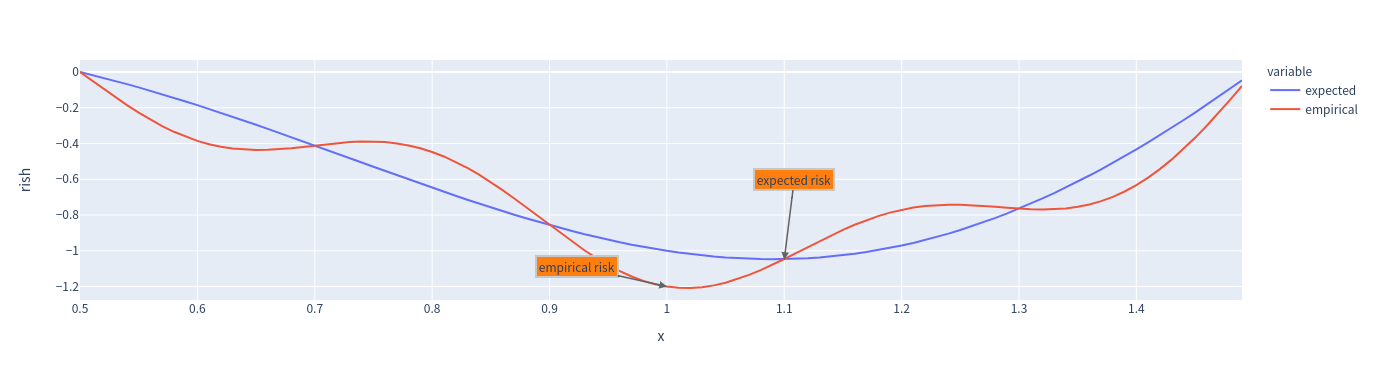

In [45]:
def annotations_set():
    return dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=2,
            arrowwidth=1.5,
            arrowcolor="#636363",
            bordercolor="#c7c7c7",
            borderwidth=2,
            bgcolor="#ff7f0e"
)

fig = px.line(df, width=600, height=380, labels={'index':'x', 'value': 'rish'})
fig.add_annotation(x=1.1, y=-1.05, text="expected risk", ax=10, ay=-80)
fig.add_annotation( x=1, y=-1.2, text="empirical risk", ax=-90, ay=-20)
fig.update_annotations(annotations_set())
fig.show()

## 2 深度学习中的优化挑战

这里主要研究优化算法，因此关注点是对目标函数优化的性能而不是神经网络的泛化误差。大多数的目标函数很复杂，没有解析解。

优化有许多挑战点：
+ 局部最小
+ 鞍点
+ 梯度消失

### 2.1 局部最小值

对于目标函数 $f(x)$,如果 $f(x)$ 在 $x$ 的值小于在它附近的点的 $f(x)$值，那么 $f(x)$ 为局部最小值。如果 $f(x)$在 $x$的值是在整个定义域中最小的值，它为 $f(x)$ 的全局最小值。

用下面的函数距离，理解全局最小值和局部最小值：

$$
f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0
$$

使用代码演示

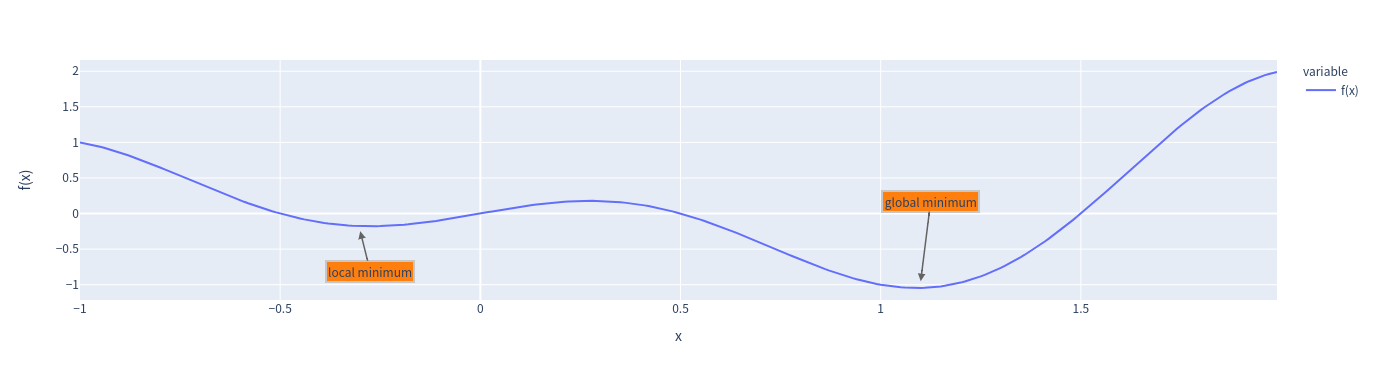

In [46]:
x = np.arange(-1.0, 2.0, 0.01)
fig = px.line(pd.DataFrame([f(x).tolist()], index=['f(x)'], columns=x.tolist()).T ,  width=600, height=380, labels = {'index': 'x', 'value': 'f(x)'})
fig.add_annotation(x=1.1, y=-0.95, text="global minimum", ax=10, ay=-80)
fig.add_annotation( x=-0.3, y=-0.25, text="local minimum", ax=10, ay=40)
fig.update_annotations(annotations_set())
fig.show()

深度学习模型的目标函数通常具有许多个局部最小值。当优化的数值接近局部最优的时候，梯度变为0,表示最终迭代获取的数值就是局部最优解，而不是全局最优。随机梯度下降就是为了解决这个问题, 迷你批上的自然变化能够使参数偏离局部最小值。

### 2.2 鞍点
除了局部最小值外，鞍点是梯度消失的另一个原因。鞍点会使函数梯度消失，但是既不是全局的不是局部的。举个例子函数$f(x) = x^3$. 其一阶和二阶导数在0处为0。0处既不是局部最优也不是全局最优，但是优化还是会停止。

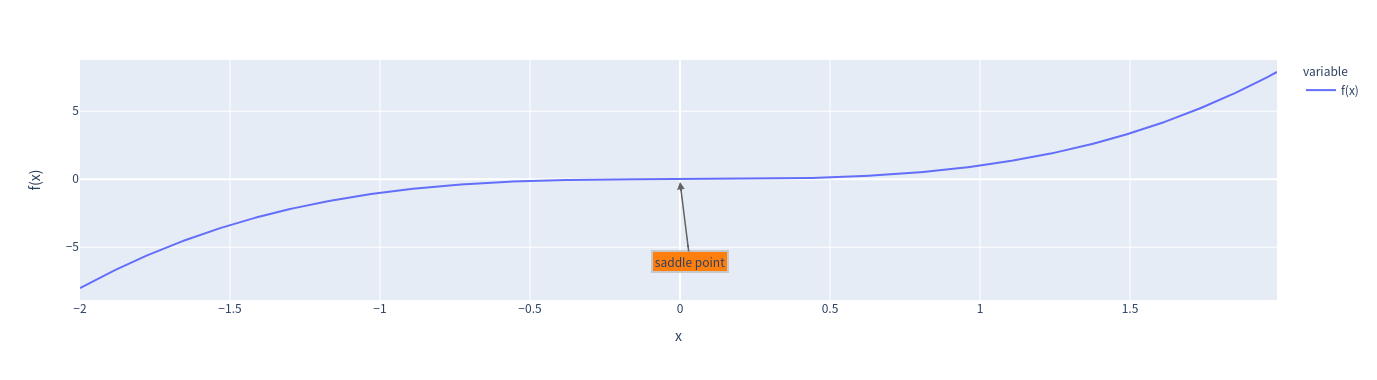

In [48]:
x = np.arange(-2.0, 2.0, 0.01)
fig = px.line(pd.DataFrame([(x**3).tolist()], index=['f(x)'], columns=x.tolist()).T ,  width=600, height=380, labels = {'index': 'x', 'value': 'f(x)'})
fig.add_annotation(x=0, y=-0.2, text="saddle point", ax=10, ay=80)
fig.update_annotations(annotations_set())
fig.show()

高维度的数据中鞍点更加隐藏。例如 $f(x, y) = x^2 - y^2$。它在 $(0, 0)$ 有一个鞍点。对于$x$来说它是最大的$y$值，它看起来像一个马鞍，所以称为鞍点。

In [74]:
x, y = np.meshgrid(np.linspace(-1.0, 1.0, 101), np.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

fig = go.Figure(data = go.Surface(z=z.asnumpy(), showscale=False, colorscale='IceFire'))
fig.update_layout(width = 600, height=580)
fig.add_annotation(x=0, y=0.3, text="saddle point", ax=30, ay=-60)
fig.update_annotations(annotations_set())
fig.show()

假设输入函数的是一个k维向量，输出位标量，因此其Hessian矩阵将具有  $k$  特征值。梯度为0时，函数的解可以为局部最小，局部最大和鞍点三种情况：
+ 当Hessian矩阵的特征值在零梯度位置都为正时，该函数有一个局部最小值
+ 当Hessian矩阵的特征值在零梯度位置都为负时，该函数有一个局部最大值
+ 当Hessian矩阵的特征值在零梯度位置有正有负，该函数有一个鞍点

简而言之，凸函数是那些Hessian特征值从不为负的函数。

### 2.3 梯度消失

可能遇到的最隐蔽的问题是梯度消失问题。例如，我们要最小化功能 $f(x) = \tanh(x)$ 并且以 $x = 4$开始。 持矢$f$接近为0。进一步求导$f'(x) = 1 - \tanh^2(x)$ 其值为 $f'(4) = 0.0013$。因此优化起初进展会很慢。这也是在使用 ReLU激活函数之前训练深度学习模型比较棘手的问题。



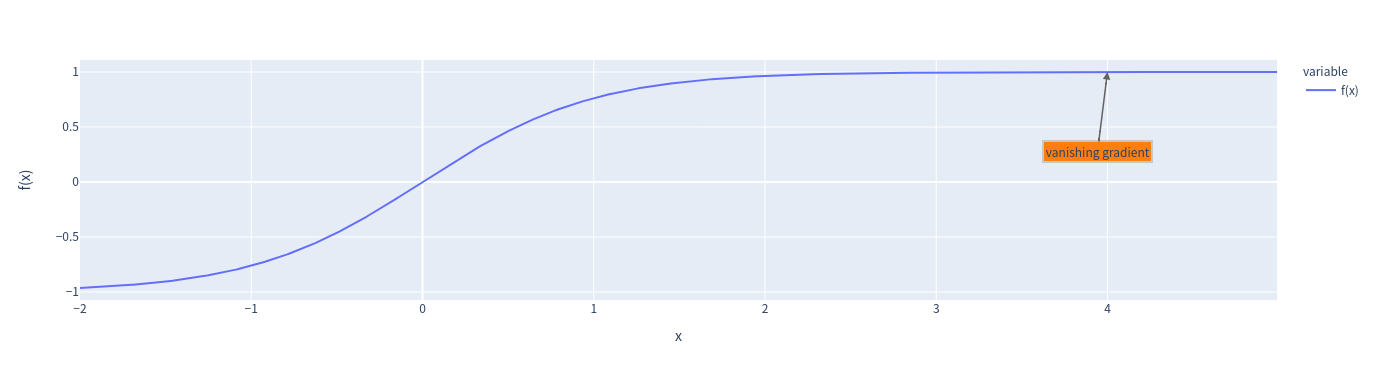

In [76]:
x = np.arange(-2.0, 5.0, 0.01)
fig = px.line(pd.DataFrame([np.tanh(x).tolist()], index=['f(x)'], columns=x.tolist()).T ,  width=600, height=380, labels = {'index': 'x', 'value': 'f(x)'})
fig.add_annotation(x=4, y=1, text="vanishing gradient", ax=-10, ay=80)
fig.update_annotations(annotations_set())
fig.show()